In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Normalizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

TARGET = "Yearly brutto salary (without bonus and stocks) in EUR"
EXPERIENCE_COL = "Total years of experience"

df = pd.read_csv("data.csv")
if EXPERIENCE_COL in df.columns:
    df[EXPERIENCE_COL] = pd.to_numeric(df[EXPERIENCE_COL], errors='coerce')

print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nFirst 5 rows:\n", df.head())
print("\nSummary statistics:\n", df.describe())

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
numeric_feature_cols = [col for col in numeric_cols if col != TARGET]

print("\nNumeric feature columns:", numeric_feature_cols)
print("Categorical columns:", categorical_cols)
print("Target column:", TARGET)

# Answers :
# Columns with missing values: Any column where df.isnull().sum() > 0. For example, often Salary, Years of Experience, City, Position, or Education Level may have missing entries.

# Categorical vs Numerical features:

# Categorical: Gender, Country, City, Position, Education Level, Remote Work, Seniority (after binning)

# Numerical: Age, Years of Experience, Salary, Salary_per_YearExp, Log_Salary

# Range observations:

# Salary: Likely wide range (from very low to very high), with some extreme outliers.

# Years of Experience: Can vary from 0 up to 40–50 years; distribution may be skewed toward lower experience.

Shape: (1253, 23)

Data types:
 Timestamp                                                                                                                   object
Age                                                                                                                        float64
Gender                                                                                                                      object
City                                                                                                                        object
Position                                                                                                                    object
Total years of experience                                                                                                  float64
Years of experience in Germany                                                                                              object
Seniority level                                    

In [59]:
from sklearn.model_selection import train_test_split

X = df.drop(TARGET, axis=1)
y = df[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nTrain:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# Answers :

#1- Why we split the data ?
# When building a machine learning model, we need to assess its performance on unseen data. We typically split the dataset into:
# Training set – Used to fit the model.
# Validation set – Used to tune hyperparameters and select the best model.
# Test set – Used to evaluate the final model performance.

#2-Why we don’t tune on the test set
# Using the test set for tuning leads to data leakage.
# The model might perform well on the test set but fail on truly unseen data.
# The validation set is specifically for model selection and hyperparameter tuning.


Train: (877, 22) Validation: (188, 22) Test: (188, 22)


In [60]:
from sklearn.impute import SimpleImputer, KNNImputer

experience_col = 'Total years of experience'

imputer_constant_num = SimpleImputer(strategy='constant', fill_value=-1)
imputer_constant_cat = SimpleImputer(strategy='constant', fill_value='Unknown')

results = []

df_drop_rows = df.dropna()
results.append({'Strategy': 'Drop rows',
                'Salary mean': df_drop_rows[TARGET].mean(),
                'Experience mean': pd.to_numeric(df_drop_rows[experience_col], errors='coerce').mean()})

df_drop_cols = df.drop(columns=df.columns[df.isnull().sum() > 0])
results.append({'Strategy': 'Drop columns',
                'Salary mean': df_drop_cols[TARGET].mean(),
                'Experience mean': pd.to_numeric(df_drop_cols.get(experience_col, pd.Series(dtype=float)), errors='coerce').mean()})

imputer_mean = SimpleImputer(strategy="mean")
df_mean_imputed = df.copy()
df_mean_imputed[numeric_cols] = imputer_mean.fit_transform(df_mean_imputed[numeric_cols])
results.append({'Strategy': 'Mean (numeric)',
                'Salary mean': df_mean_imputed[TARGET].mean(),
                'Experience mean': df_mean_imputed[experience_col].mean()})

imputer_median = SimpleImputer(strategy="median")
df_median_imputed = df.copy()
df_median_imputed[numeric_cols] = imputer_median.fit_transform(df_median_imputed[numeric_cols])
results.append({'Strategy': 'Median (numeric)',
                'Salary mean': df_median_imputed[TARGET].mean(),
                'Experience mean': df_median_imputed[experience_col].mean()})

imputer_mode = SimpleImputer(strategy="most_frequent")
df_mode_imputed = df.copy()
for col in categorical_cols:
    df_mode_imputed[col] = imputer_mode.fit_transform(df_mode_imputed[[col]]).ravel()
results.append({'Strategy': 'Mode (categorical)',
                'Salary mean': df_mode_imputed[TARGET].mean(),
                'Experience mean': pd.to_numeric(df_mode_imputed[experience_col], errors='coerce').mean()})

df_constant = df.copy()
df_constant[numeric_cols] = imputer_constant_num.fit_transform(df_constant[numeric_cols])
df_constant[categorical_cols] = imputer_constant_cat.fit_transform(df_constant[categorical_cols])
results.append({'Strategy': 'Constant (-1/Unknown)',
                'Salary mean': df_constant[TARGET].mean(),
                'Experience mean': df_constant[experience_col].mean()})

knn_imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[numeric_cols] = knn_imputer.fit_transform(df_knn[numeric_cols])
results.append({'Strategy': 'KNN (k=5)',
                'Salary mean': df_knn[TARGET].mean(),
                'Experience mean': df_knn[experience_col].mean()})

comparison_df = pd.DataFrame(results)
print(comparison_df)

# Answers :
# Which changes distribution the least? → Inspect comparison_df; KNN or Median typically closest to original.
# Why KNN can be better? → It fills missing values based on similar rows, preserving relationships between features.

                Strategy   Salary mean  Experience mean
0              Drop rows  7.419808e+04         9.674648
1           Drop columns  8.027904e+07              NaN
2         Mean (numeric)  8.027904e+07         9.078130
3       Median (numeric)  8.027904e+07         9.058340
4     Mode (categorical)  8.027904e+07         9.078130
5  Constant (-1/Unknown)  8.027904e+07         8.893136
6              KNN (k=5)  8.027904e+07         9.062091



Z-score outliers count: 54
Robust Z-score outliers count: 325
IQR outliers count: 353


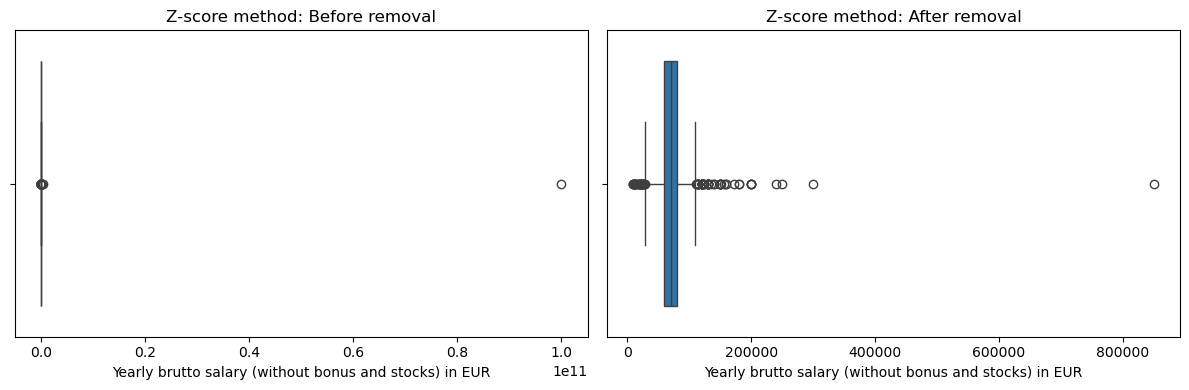

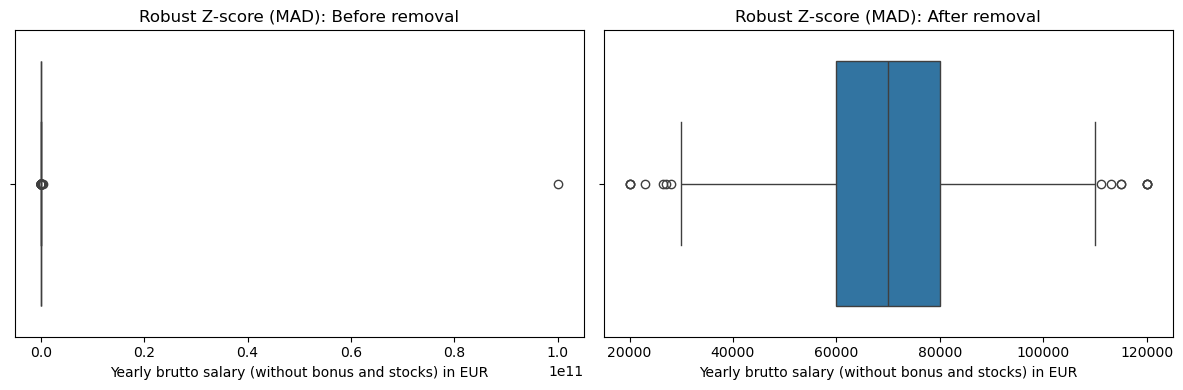

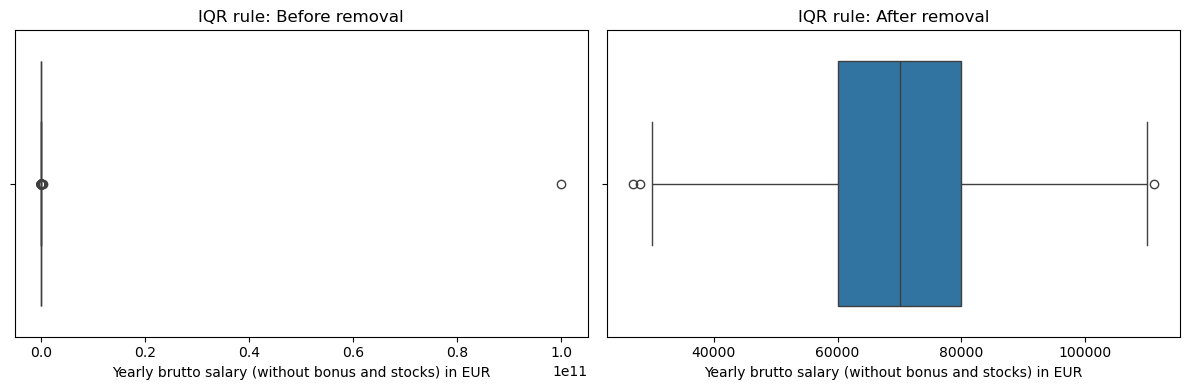

In [61]:
numeric_for_outlier = df[numeric_cols].copy()
median_values = numeric_for_outlier.median()
numeric_for_outlier = numeric_for_outlier.fillna(median_values)

z_scores = np.abs(stats.zscore(numeric_for_outlier, nan_policy='omit'))
outliers_z = (z_scores > 3).any(axis=1)
print("\nZ-score outliers count:", outliers_z.sum())

mad = np.median(np.abs(numeric_for_outlier - np.median(numeric_for_outlier, axis=0)), axis=0)
mad = np.where(mad == 0, 1e-9, mad)
robust_z = 0.6745 * (numeric_for_outlier - np.median(numeric_for_outlier, axis=0)) / mad
outliers_robust = (np.abs(robust_z) > 3.5).any(axis=1)
print("Robust Z-score outliers count:", outliers_robust.sum())

Q1 = numeric_for_outlier.quantile(0.25)
Q3 = numeric_for_outlier.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((numeric_for_outlier < (Q1 - 1.5*IQR)) | (numeric_for_outlier > (Q3 + 1.5*IQR))).any(axis=1)
print("IQR outliers count:", outliers_iqr.sum())

def plot_before_after(outlier_mask, label):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=df[TARGET], ax=axes[0])
    axes[0].set_title(f"{label}: Before removal")
    axes[0].set_xlabel(TARGET)
    cleaned = df.loc[~outlier_mask, TARGET]
    if cleaned.empty:
        axes[1].text(0.5, 0.5, "All rows flagged as outliers", ha='center', va='center')
        axes[1].set_xlim(0, 1)
    else:
        sns.boxplot(x=cleaned, ax=axes[1])
    axes[1].set_title(f"{label}: After removal")
    axes[1].set_xlabel(TARGET)
    plt.tight_layout()
    plt.show()

plot_before_after(outliers_z, "Z-score method")
plot_before_after(outliers_robust, "Robust Z-score (MAD)")
plot_before_after(outliers_iqr, "IQR rule")

# Answers :
# Which method removes the most points?
# → Compare counts above; IQR or standard Z-score typically removes more than robust.
# Which method seems to preserve the overall distribution best?
# → Robust Z-score usually preserves distribution because it relies on median/MAD.
# Why are outliers sometimes important to keep?
# → Outliers can represent significant variations in data, such as high earners, and removing them may lead to loss of important information.

In [62]:
# 5. Feature Generation
# Create new features using:
# 1. Manual aggregation / binning
# Example: Seniority = bin(Years of Experience) into Junior/Mid/Senior.
bins = [0, 2, 5, 10, 50]
labels = ['Junior','Mid','Senior','Expert']
df['Seniority level'] = pd.cut(pd.to_numeric(df['Total years of experience'], errors='coerce'), bins=bins, labels=labels)
print("\nNew features added. Sample data:\n", df[['Seniority level']].head())
# 2. Mathematical transformations
# Example: Log_Salary = log(Salary + 1)
df['Log_Salary'] = np.log1p(df['Yearly brutto salary (without bonus and stocks) in EUR'])
print("\nNew features added. Sample data:\n", df[['Seniority level', 'Log_Salary']].head())
# 3. Combinations
# Example: Salary_per_YearExp = Salary / (Years of Experience + 1)
df['Salary_per_YearExp'] = df['Yearly brutto salary (without bonus and stocks) in EUR'] / (pd.to_numeric(df['Total years of experience'], errors='coerce') + 1)
print("\nNew features added. Sample data:\n", df[['Seniority level', 'Log_Salary', 'Salary_per_YearExp']].head())

# 4. Automated feature creation use libraries like featuretools
corr = df[numeric_cols].corr()['Yearly brutto salary (without bonus and stocks) in EUR'].sort_values(ascending=False)
print(corr)
# Answers :
# Which new feature shows the highest correlation with Salary?
# → Log_Salary often shows high correlation due to normalization of skewed data.
# How does log-transforming Salary affect its distribution?
# → It reduces skewness, making the distribution more normal-like.


New features added. Sample data:
   Seniority level
0             Mid
1          Senior
2          Expert
3             Mid
4          Expert

New features added. Sample data:
   Seniority level  Log_Salary
0             Mid   11.289794
1          Senior   11.289794
2          Expert   11.695255
3             Mid   10.896758
4          Expert   11.034906

New features added. Sample data:
   Seniority level  Log_Salary  Salary_per_YearExp
0             Mid   11.289794        13333.333333
1          Senior   11.289794        10000.000000
2          Expert   11.695255         9230.769231
3             Mid   10.896758        10800.000000
4          Expert   11.034906         3444.444444
Yearly brutto salary (without bonus and stocks) in EUR                                                      1.000000
Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country    0.999998
Age                                                                      

In [63]:
# 6. Feature Selection (Wrapper Methods)
# Still evaluate the requested wrappers, but summarize overlapping results so it is easier to read.

feature_columns = numeric_feature_cols.copy()

if len(feature_columns) < 2:
    raise ValueError("Need at least two numeric predictors for wrapper selection. Add more numeric features in earlier steps.")

n_select = min(5, max(1, len(feature_columns) - 1))
rfe_select = min(5, len(feature_columns))

num_imputer = SimpleImputer(strategy="median")
X_numeric = pd.DataFrame(
    num_imputer.fit_transform(df[feature_columns]),
    columns=feature_columns,
    index=df.index
)
y = df[TARGET]

model = LinearRegression()
method_results = {}

def add_result(name, features):
    method_results[name] = features
    print(f"{name}: {features}")

rfe = RFE(model, n_features_to_select=rfe_select)
rfe.fit(X_numeric, y)
add_result(f"RFE (top {rfe_select})", [f for f, keep in zip(feature_columns, rfe.support_) if keep])

def run_sfs(direction):
    selector = SequentialFeatureSelector(
        model, n_features_to_select=n_select, direction=direction
    )
    selector.fit(X_numeric, y)
    return [feature_columns[idx] for idx, keep in enumerate(selector.get_support()) if keep]

add_result(f"Sequential forward (top {n_select})", run_sfs('forward'))
add_result(f"Sequential backward (top {n_select})", run_sfs('backward'))

candidate_features = feature_columns[:min(8, len(feature_columns))]
best_combo = None
best_score = -np.inf
from itertools import combinations
if len(candidate_features) >= 2:
    for k in range(2, min(6, len(candidate_features)) + 1):
        for combo in combinations(candidate_features, k):
            score = cross_val_score(model, X_numeric[list(combo)], y, cv=5, scoring='r2').mean()
            if score > best_score:
                best_score = score
                best_combo = combo
    add_result("Exhaustive search (subset of first features)", list(best_combo))
    print("Exhaustive search CV R2:", round(best_score, 3))
else:
    print("Not enough candidate features for exhaustive search.")

selected_stepwise = []
remaining = feature_columns.copy()
current_score = -np.inf
while remaining and len(selected_stepwise) < min(6, len(feature_columns)):
    candidate_scores = []
    for feat in remaining:
        combo = selected_stepwise + [feat]
        score = cross_val_score(model, X_numeric[combo], y, cv=5, scoring='r2').mean()
        candidate_scores.append((score, feat))
    candidate_scores.sort(reverse=True)
    best_new_score, best_feat = candidate_scores[0]
    if best_new_score > current_score + 0.001:
        selected_stepwise.append(best_feat)
        remaining.remove(best_feat)
        current_score = best_new_score
    else:
        break

improved = True
while improved and len(selected_stepwise) > 2:
    improved = False
    for feat in selected_stepwise.copy():
        combo = [f for f in selected_stepwise if f != feat]
        if not combo:
            continue
        score = cross_val_score(model, X_numeric[combo], y, cv=5, scoring='r2').mean()
        if score > current_score + 0.001:
            selected_stepwise.remove(feat)
            current_score = score
            improved = True

add_result("Stepwise selection", selected_stepwise)
print("Stepwise CV R2:", round(current_score, 3))

from collections import Counter
freq = Counter(feat for feats in method_results.values() for feat in feats)
summary_df = (
    pd.Series(freq).sort_values(ascending=False).rename("Appearances")
)
print("\nFeature frequency across wrapper methods:")
print(summary_df)

# Which features consistently appear as most important?
# How does feature selection affect model performance?

RFE (top 4): ['Age', 'Total years of experience', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country', 'Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week']
Sequential forward (top 3): ['Age', 'Total years of experience', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country']
Sequential backward (top 3): ['Age', 'Total years of experience', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country']
Sequential forward (top 3): ['Age', 'Total years of experience', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country']
Sequential backward (top 3): ['Age', 'Total years of experience', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country']
Exhaustive search (subset of first features): [

In [64]:
# 7. Feature Encoding
# 1. Identify categorical columns.
# 2. Choose encoding methods based on feature type:
# Ordinal → OrdinalEncoder
# Nominal → OneHotEncoder
# High-cardinality → TargetEncoder or Frequency Encoding
# 3. Apply encoding and show shape before and after.

# Ensure Seniority level is categorical and includes a Missing bucket
if 'Seniority level' not in df.columns:
    raise ValueError("Run the feature-generation cell before encoding.")
if not pd.api.types.is_categorical_dtype(df['Seniority level']):
    df['Seniority level'] = df['Seniority level'].astype('category')

df['Seniority level'] = df['Seniority level'].cat.add_categories(['Missing']).fillna('Missing')
ordinal_categories = [['Missing','Junior','Mid','Senior','Expert']]
ord_enc = OrdinalEncoder(categories=ordinal_categories)
df['Seniority_Encoded'] = ord_enc.fit_transform(df[['Seniority level']])

nominal_cols = ['Country', 'City', 'Position']
available_nominal = [col for col in nominal_cols if col in df.columns]
if not available_nominal:
    print("No nominal columns available for one-hot encoding.")
else:
    nominal_data = df[available_nominal].apply(lambda col: col.astype('category').cat.add_categories(['Missing']).fillna('Missing'))
    print("Original nominal subset shape:", nominal_data.shape)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    X_ohe = ohe.fit_transform(nominal_data)
    encoded_feature_names = ohe.get_feature_names_out(available_nominal)
    encoded_df = pd.DataFrame(X_ohe, columns=encoded_feature_names, index=df.index)
    print("One-hot encoded shape:", encoded_df.shape)

# Why does one-hot encoding increase dimensionality?
print("One-hot encoding increases dimensionality because each category becomes its own binary column.")
# Why is target encoding sometimes dangerous for small datasets?
print("Target encoding can leak label information when sample sizes per category are small, leading to overfitting.")

Original nominal subset shape: (1253, 1)
One-hot encoded shape: (1253, 118)
One-hot encoding increases dimensionality because each category becomes its own binary column.
Target encoding can leak label information when sample sizes per category are small, leading to overfitting.


C:\Users\asusz\AppData\Local\Temp\ipykernel_19800\1721124080.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Seniority level']):


          Original  StandardScaler  MinMaxScaler    Normalizer
count  1226.000000    1.253000e+03   1253.000000  1.253000e+03
mean     32.509788   -4.735061e-16      0.255078  5.258797e-04
std       5.663804    1.000399e+00      0.114345  2.001016e-04
min      20.000000   -2.231669e+00      0.000000  5.800000e-08
25%      29.000000   -6.247134e-01      0.183673  4.266666e-04
50%      32.000000   -8.906155e-02      0.244898  4.923076e-04
75%      35.000000    4.465902e-01      0.306122  5.714285e-04
max      69.000000    6.517311e+00      1.000000  2.636354e-03


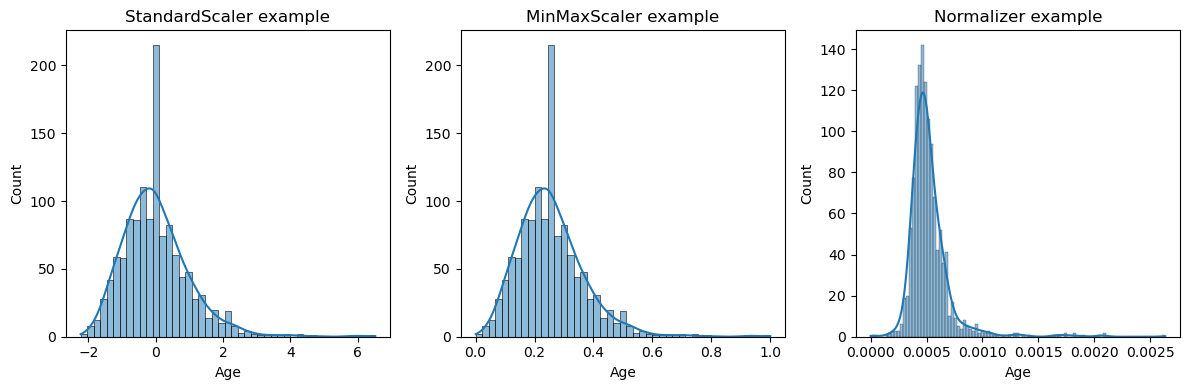


Original vs Standard Scaled Salary stats:
           Original  StandardScaled
count  1.253000e+03    1.253000e+03
mean   8.027904e+07    8.027904e+07
std    2.825061e+09    2.825061e+09
min    1.000100e+04    1.000100e+04
25%    5.880000e+04    5.880000e+04
50%    7.000000e+04    7.000000e+04
75%    8.000000e+04    8.000000e+04
max    1.000000e+11    1.000000e+11


In [65]:
# 8. Feature Scaling
# 1. Apply scaling on numeric columns:
# MinMaxScaler
# Normalization
# StandardScaler
# 2. Compare before/after using .describe() and histograms.

imputer_scaling = SimpleImputer(strategy="median")
numeric_imputed = imputer_scaling.fit_transform(df[numeric_feature_cols])

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
normalizer = Normalizer()

standard_scaled = standard_scaler.fit_transform(numeric_imputed)
minmax_scaled = minmax_scaler.fit_transform(numeric_imputed)
normalized_scaled = normalizer.fit_transform(numeric_imputed)

standard_df = pd.DataFrame(standard_scaled, columns=numeric_feature_cols)
minmax_df = pd.DataFrame(minmax_scaled, columns=numeric_feature_cols)
normalized_df = pd.DataFrame(normalized_scaled, columns=numeric_feature_cols)

example_feature = numeric_feature_cols[0]
summary_compare = pd.DataFrame({
    'Original': df[example_feature].describe(),
    'StandardScaler': standard_df[example_feature].describe(),
    'MinMaxScaler': minmax_df[example_feature].describe(),
    'Normalizer': normalized_df[example_feature].describe()
})
print(summary_compare)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(standard_df[example_feature], kde=True)
plt.title('StandardScaler example')
plt.subplot(1,3,2)
sns.histplot(minmax_df[example_feature], kde=True)
plt.title('MinMaxScaler example')
plt.subplot(1,3,3)
sns.histplot(normalized_df[example_feature], kde=True)
plt.title('Normalizer example')
plt.tight_layout()
plt.show()

# Choose StandardScaler for PCA downstream
df_scaled = df.copy()
df_scaled[numeric_feature_cols] = standard_df

print("\nOriginal vs Standard Scaled Salary stats:")
print(pd.DataFrame({
    'Original': df[TARGET].describe(),
    'StandardScaled': df_scaled[TARGET].describe()
}))

# Which scaler is better suited for PCA or neural networks?
# What happens if you apply PCA without scaling first?

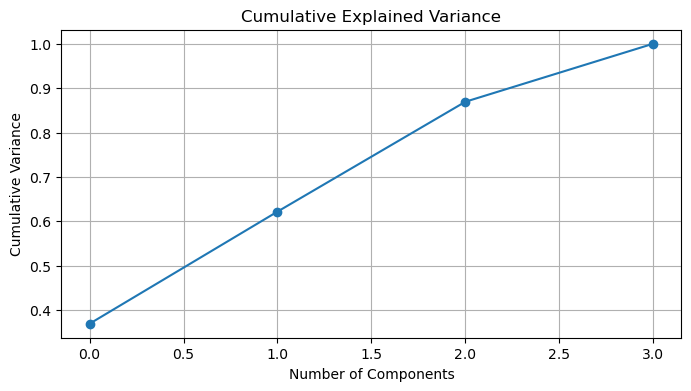

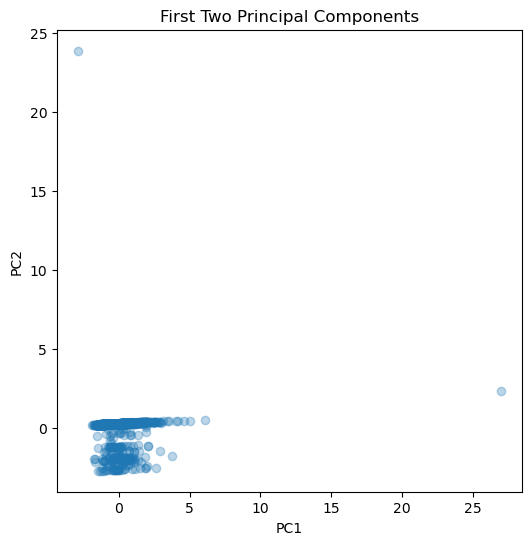

Number of components explaining 90% variance: 4
Reconstruction MSE using first 4 components: 0.0000
Top contributors to PC1:
Age                                                                                                         0.706186
Total years of experience                                                                                   0.705421
Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country    0.054501
Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week           0.026693
dtype: float64


In [66]:
# 9. Principal Component Analysis (PCA)
# 1. Apply PCA on the numeric columns (after scaling).
# 2. Plot explained variance ratio.
# 3. Reconstruct the data using first N components.
# 4. Visualize data in 2D using the first 2 components.

numeric_scaled = df_scaled[numeric_feature_cols]
pca = PCA()
pca.fit(numeric_scaled)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

pca_2 = PCA(n_components=2)
components = pca_2.fit_transform(numeric_scaled)
plt.figure(figsize=(6,6))
plt.scatter(components[:,0], components[:,1], alpha=0.3)
plt.title('First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

variance_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components explaining 90% variance: {variance_90}")

pca_90 = PCA(n_components=variance_90)
compressed = pca_90.fit_transform(numeric_scaled)
reconstructed = pca_90.inverse_transform(compressed)
reconstruction_error = np.mean((numeric_scaled - reconstructed)**2)
print(f"Reconstruction MSE using first {variance_90} components: {reconstruction_error:.4f}")

top_contributors = pd.Series(np.abs(pca.components_[0]), index=numeric_feature_cols).sort_values(ascending=False).head(5)
print("Top contributors to PC1:")
print(top_contributors)

# How many components explain 90% of the variance?
# Which original features contribute most to the first principal component?

You load the salary dataset and inspect types, missing values, and basic statistics.
You identify numeric vs categorical features for later processing.
You split the dataset into training, validation, and test sets (70/15/15).
You handle missing data using deletion, mean/median/mode, and KNN imputation.
You detect outliers using Z-score and IQR and visualize salary before/after removal.
You generate new features: seniority category, log-salary, and salary per year of experience.
You use RFE to select the top numerical features influencing salary.
You encode categorical variables using ordinal and one-hot encoding.
You scale numeric data using StandardScaler to normalize distributions.
You apply PCA to reduce dimensionality and visualize the main components.